In [158]:
import requests as r
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
# Warning: libraries below not included in basic project file
import pickle
import wikipedia
import matplotlib.pyplot as plt

In [159]:
USE_PICKLED_DATA=True # Set false to get fresh data from the web, otherwise use the pickled data

## Scraping  `topuniversities.com`

In [2]:
URL = 'https://www.topuniversities.com'

In [3]:
data = r.get(URL + '/sites/default/files/qs-rankings-data/357051.txt').json()['data']

We want to filter by rank and extract the above properties. Some ranks are of the form: `X-Y` to indicate a range and some start with a `=` to indicate that two universities reached the same rank. As these formats complicate parsing, we first want to check whether the universities we interested in (the top 200) have their rank expressed in one of the two formats:

In [4]:
dash = set()
equals = set()
for uni in data:
    rank = uni['rank_display']
    if '-' in rank:
        dash.add(rank)
    if '=' in rank:
        equals.add(int(rank.lstrip('=')))

In [5]:
dash

{'401-410',
 '411-420',
 '421-430',
 '431-440',
 '441-450',
 '451-460',
 '461-470',
 '471-480',
 '481-490',
 '491-500',
 '501-550',
 '551-600',
 '601-650',
 '651-700',
 '701-750',
 '751-800',
 '801-1000'}

None of the intervals is relevant for our analysis

In [6]:
any(map(lambda v: v < 201, equals))

True

Some of the values starting with `=` are interesting for us.

In [7]:
fields = (
    'title',
    'country',
    'region',
    'url'
)

# Obtained by inspecting html source
to_scrape = (
    'total student',
    'total inter',
    'total faculty',
    'inter faculty'
)

In [8]:
# ============================= DO NOT EXECUTE IF ALREADY HAVE PICKLE FILE =======================================
if not USE_PICKLED_DATA:
    cleaned = []

    # As explained above, we are not interested in ranks with '-'
    for uni in filter(lambda u: '-' not in u['rank_display'], data):
        # parse rank
        rank = uni['rank_display']
        rank = np.uint32(rank.lstrip('='))

        # Only keep universities in top 200
        if rank < 201:
            # Retain important fields from ranking table
            clean_uni = {variable: uni[variable] for variable in fields}
            clean_uni['rank'] = rank

            cleaned.append(clean_uni)

            # Retrieve data from university page
            req = r.get(URL + uni['url'])
            soup = BeautifulSoup(req.text, 'html.parser')
            for field in to_scrape:
                div = soup.find('div', class_=field)
                if div:
                    clean_uni[field] = np.uint32(div.find('div', class_='number')\
                                                   .text.strip().replace(',', ''))
                else:
                    print('Could not find', field, 'for', uni['title'])

Could not find total student for New York University (NYU)
Could not find total inter for New York University (NYU)
Could not find total faculty for New York University (NYU)
Could not find inter faculty for New York University (NYU)
Could not find inter faculty for Indian Institute of Science (IISc) Bangalore


In [10]:
if not USE_PICKLED_DATA:
    # To work without having to pull everything down.
    with open('bcp.pickle', 'wb') as out:
        pickle.dump(cleaned, out)

In [118]:
with open('bcp.pickle', 'rb') as data_source:
    cleaned = pickle.load(data_source)

In [119]:
topuniversities = pd.DataFrame(cleaned)

In [120]:
topuniversities.head(10)

,country,inter faculty,rank,region,title,total faculty,total inter,total student,url
0,United States,1679.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...
1,United States,2042.0,2,North America,Stanford University,4285.0,3611.0,15878.0,/universities/stanford-university
2,United States,1311.0,3,North America,Harvard University,4350.0,5266.0,22429.0,/universities/harvard-university
3,United States,350.0,4,North America,California Institute of Technology (Caltech),953.0,647.0,2255.0,/universities/california-institute-technology-...
4,United Kingdom,2278.0,5,Europe,University of Cambridge,5490.0,6699.0,18770.0,/universities/university-cambridge
5,United Kingdom,2964.0,6,Europe,University of Oxford,6750.0,7353.0,19720.0,/universities/university-oxford
6,United Kingdom,2554.0,7,Europe,UCL (University College London),6345.0,14854.0,31080.0,/universities/ucl-university-college-london
7,United Kingdom,2071.0,8,Europe,Imperial College London,3930.0,8746.0,16090.0,/universities/imperial-college-london
8,United States,635.0,9,North America,University of Chicago,2449.0,3379.0,13557.0,/universities/university-chicago
9,Switzerland,1886.0,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,2477.0,7563.0,19815.0,/universities/eth-zurich-swiss-federal-institu...


## Scraping timeshighereducation.com

In [121]:
URL = 'https://www.timeshighereducation.com'

In [122]:
data = r.get(URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json').json()['data']

In [123]:
dash = set()
equals = set()
plus = set()
for uni in data:
    rank = uni['rank']
    if '–' in rank:
        dash.add(rank)
    if '=' in rank:
        equals.add(int(rank.lstrip('=')))
    if '+' in rank:
        plus.add(rank)

In [124]:
dash

{'201–250',
 '251–300',
 '301–350',
 '351–400',
 '401–500',
 '501–600',
 '601–800',
 '801–1000'}

In [125]:
any(map(lambda v: v < 201, equals))

True

In [126]:
plus

{'1001+'}

In [127]:
def highereducation_university_builder(uni):
    intern_ratio = 0.01 * np.float32(uni['stats_pc_intl_students'].rstrip('%'))
    staff_ratio = np.float32(uni['stats_student_staff_ratio'])
    res = {
        'title': uni['name'],
        'country': uni['location'],
        'url': uni['url'],
        'total student': np.int32(uni['stats_number_students'].replace(',', ''))
    }
    # Having float number of person is not very relevent
    # Because of this we round the result to have an integer value
    res['total inter'] = np.round(intern_ratio * res['total student'])
    res['total faculty'] = np.round(res['total student'] / staff_ratio)
    return res

In [128]:
cleaned = []
region_not_found = []
for uni in filter(lambda u: all(map(lambda sym: sym not in u['rank'], ('–', '+'))), data):
    rank = uni['rank']
    rank = np.int32(rank.lstrip('='))
    if rank < 201:
        clean_uni = highereducation_university_builder(uni)
        clean_uni['rank'] = rank
        # To add region to clean_uni, we use the regions from topuniversities
        try:
            clean_uni['region'] =  topuniversities[topuniversities['country'] == clean_uni['country']]['region'].iloc[0]
        except:
            print("Couldn't find region for uni {}".format(clean_uni['title']))
            region_not_found.append(clean_uni)
        cleaned.append(clean_uni)

Couldn't find region for uni University of Luxembourg
Couldn't find region for uni Lomonosov Moscow State University


In [129]:
highereducation = pd.DataFrame(cleaned)

We manually set the regions for the universities for which no region could be found

<span class="burk">TODO: Check if this is acceptable!</span>

Moscow is considered to be on the European continent (https://en.wikipedia.org/wiki/Moscow)
Because of this we can use a loop to set the values

In [130]:
for not_found in region_not_found: 
    loc = highereducation['title'] == not_found['title']
    highereducation = highereducation.set_value(loc, 'region', 'Europe')

In [131]:
highereducation.head(10)

,country,rank,region,title,total faculty,total inter,total student,url
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford
1,United Kingdom,2,Europe,University of Cambridge,1687.0,6436.0,18389,/world-university-rankings/university-cambridge
2,United States,3,North America,California Institute of Technology,340.0,596.0,2209,/world-university-rankings/california-institut...
3,United States,3,North America,Stanford University,2113.0,3486.0,15845,/world-university-rankings/stanford-university
4,United States,5,North America,Massachusetts Institute of Technology,1285.0,3800.0,11177,/world-university-rankings/massachusetts-insti...
5,United States,6,North America,Harvard University,2284.0,5285.0,20326,/world-university-rankings/harvard-university
6,United States,7,North America,Princeton University,958.0,1909.0,7955,/world-university-rankings/princeton-university
7,United Kingdom,8,Europe,Imperial College London,1391.0,8721.0,15857,/world-university-rankings/imperial-college-lo...
8,United States,9,North America,University of Chicago,2181.0,3381.0,13525,/world-university-rankings/university-chicago
9,Switzerland,10,Europe,ETH Zurich – Swiss Federal Institute of Techno...,1317.0,7309.0,19233,/world-university-rankings/eth-zurich-swiss-fe...


## Analysis of the university rankings

In this section, we will answer the following questions for both of the university rankings:

- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.


### Definition of usefull functions and tools for the analysis

In [22]:
# Spice up our print display
# Taken from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Example:
print(color.BOLD + 'Hello World !' + color.END)

END_STR = color.END
BU_STR  = color.BOLD+color.UNDERLINE


Hello World !


In [23]:
# Lets define a useful order of columns that we find meaningful:
TOP_UNI_BASE_COL=["rank", "country", "region", "title"]
FAC_STUD_RATIO_COL=["total faculty", "total student", "faculty student ratio"]
INTER_STUD_RATIO_COL=["total inter", "total student", "inter student ratio"]

** We define to usefull functions to do the sorting by ratio for us and print the results **

In [187]:
def ratio_analysis_per_school(university_df):
    """ This function takes a dataframe and will analyse the ratio of facutly
    member to student as well as the ratio of internatioal students to students.
    It will do so for each schools it contains
    It will print the result in a nicely formatted way
    
    Keywords:
    university_df -- DataFrame containing the university data
    """
    university_df["faculty student ratio"] = university_df["total faculty"]/university_df["total student"]
    university_df["inter student ratio"]   = university_df["total inter"]/university_df["total student"]

    # In the display, only output meaningful information regarding to the filter at hand
    print(BU_STR+"Dataframe with ratios"+END_STR)
    display(university_df.head(10))

    print(BU_STR + "Schools sorted by their faculty to student ratio" + END_STR)
    display(university_df.sort_values("faculty student ratio", ascending=False)[TOP_UNI_BASE_COL+FAC_STUD_RATIO_COL].head(10))
    plt.figure(1)
    university_df["faculty student ratio"].plot(kind="hist",
                                                title="Faculty to student ratios")
    plt.show()

    print(BU_STR + "Schools sorted by their international student ratio" + END_STR)
    display(university_df.sort_values("inter student ratio", ascending=False)[TOP_UNI_BASE_COL+INTER_STUD_RATIO_COL].head(10))
    plt.figure(2)
    university_df["inter student ratio"].plot(kind="hist",
                                              title="International student ratios")
    plt.show()
    

In [191]:
def ratio_analysis_per_column(university_df, column_name):
    """ This function takes a dataframe and will analyse the ratio if facutly
    member to student as well as the ratio of internatioal students to students.
    It will do so by aggregating the elements sharing the same value in the column_name column.
    It will print the result in a nicely formatted way
    
    Keywords:
    university_df -- DataFrame containing the university data
    column_name   -- Name of the column for which the values of same-name entry will be aggregated
    """
    
    # The metodology used in this answer comes from: https://stackoverflow.com/questions/35307732/how-to-sum-in-pandas-by-unique-index-in-several-columns
    university_df_country =university_df.groupby(column_name)["total inter", "total student", "total faculty"].sum().reset_index()
    university_df_country["faculty student ratio"] = university_df_country["total faculty"]/university_df_country["total student"]
    university_df_country["inter student ratio"]   = university_df_country["total inter"]/university_df_country["total student"]

    print(BU_STR+"Resulting dataframe sorted by {}".format(column_name)+END_STR)
    display(university_df_country.head(10))

    print(BU_STR+"{} sorted by their faculty to student ratio".format(column_name)+END_STR)
    display(university_df_country.sort_values("faculty student ratio", ascending=False)[[column_name]+FAC_STUD_RATIO_COL].head(10))
    plt.figure(1)
    university_df_country["faculty student ratio"].plot(kind="hist",
                                                title="Faculty to student ratios")
    plt.show()

    print(BU_STR+"{} sorted by their international student ratio".format(column_name)+END_STR)
    display(university_df_country.sort_values("inter student ratio", ascending=False)[[column_name]+INTER_STUD_RATIO_COL].head(10))
    plt.figure(1)
    university_df_country["inter student ratio"].plot(kind="hist",
                                                title="International student ratios")
    plt.show()   

### Analysis of ratios for the website topuniversities.com

Analysis of faculty to student ratio and international student ratio per school

Dataframe with ratios


,country,inter faculty,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United States,1679.0,1,North America,Massachusetts Institute of Technology,2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...,0.269450,0.335863
1,United States,2042.0,2,North America,Stanford University,4285.0,3611.0,15878.0,/universities/stanford-university,0.269870,0.227422
2,United States,1311.0,3,North America,Harvard University,4350.0,5266.0,22429.0,/universities/harvard-university,0.193945,0.234785
3,United States,350.0,4,North America,California Institute of Technology,953.0,647.0,2255.0,/universities/california-institute-technology-...,0.422616,0.286918
4,United Kingdom,2278.0,5,Europe,University of Cambridge,5490.0,6699.0,18770.0,/universities/university-cambridge,0.292488,0.356899
5,United Kingdom,2964.0,6,Europe,University of Oxford,6750.0,7353.0,19720.0,/universities/university-oxford,0.342292,0.372870
6,United Kingdom,2554.0,7,Europe,University College London,6345.0,14854.0,31080.0,/universities/ucl-university-college-london,0.204151,0.477928
7,United Kingdom,2071.0,8,Europe,Imperial College London,3930.0,8746.0,16090.0,/universities/imperial-college-london,0.244251,0.543567
8,United States,635.0,9,North America,University of Chicago,2449.0,3379.0,13557.0,/universities/university-chicago,0.180645,0.249244
9,Switzerland,1886.0,10,Europe,ETH Zurich,2477.0,7563.0,19815.0,/universities/eth-zurich-swiss-federal-institu...,0.125006,0.381681


Schools sorted by their faculty to student ratio


,rank,country,region,title,total faculty,total student,faculty student ratio
3,4,United States,North America,California Institute of Technology,953.0,2255.0,0.422616
15,16,United States,North America,Yale University,4940.0,12402.0,0.398323
5,6,United Kingdom,Europe,University of Oxford,6750.0,19720.0,0.342292
4,5,United Kingdom,Europe,University of Cambridge,5490.0,18770.0,0.292488
16,17,United States,North America,Johns Hopkins University,4462.0,16146.0,0.276353
1,2,United States,North America,Stanford University,4285.0,15878.0,0.269870
0,1,United States,North America,Massachusetts Institute of Technology,2982.0,11067.0,0.269450
185,186,United States,North America,University of Rochester,2569.0,9636.0,0.266604
18,19,United States,North America,University of Pennsylvania,5499.0,20639.0,0.266437
17,18,United States,North America,Columbia University,6189.0,25045.0,0.247115


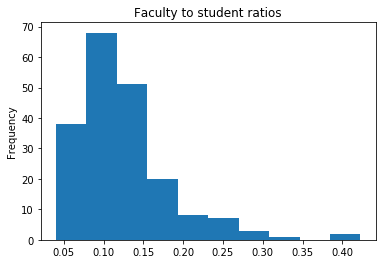

Schools sorted by their international student ratio


,rank,country,region,title,total inter,total student,inter student ratio
34,35,United Kingdom,Europe,London School of Economics,6748.0,9760.0,0.691393
11,12,Switzerland,Europe,École Polytechnique Fédérale de Lausanne,5896.0,10343.0,0.570047
7,8,United Kingdom,Europe,Imperial College London,8746.0,16090.0,0.543567
198,200,Netherlands,Europe,Maastricht University,8234.0,16385.0,0.502533
47,47,United States,North America,Carnegie Mellon University,6385.0,13356.0,0.478062
6,7,United Kingdom,Europe,University College London,14854.0,31080.0,0.477928
91,92,United Kingdom,Europe,University of St Andrews,4030.0,8800.0,0.457955
41,41,Australia,Oceania,University of Melbourne,18030.0,42182.0,0.427434
126,127,United Kingdom,Europe,Queen Mary University of London,6806.0,16135.0,0.421816
25,26,Hong Kong,Asia,University of Hong Kong,8230.0,20214.0,0.407144


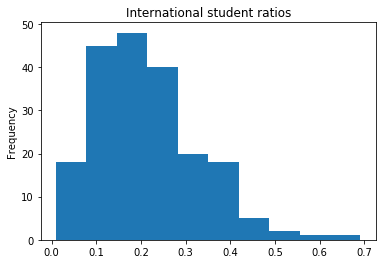

In [192]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per school\n"+END_STR)
ratio_analysis_per_school(topuniversities)

Analysis of faculty to student ratio and international student ratio per country

Resulting dataframe sorted by country


,country,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Argentina,27109.0,122301.0,16421.0,0.134267,0.221658
1,Australia,106359.0,301994.0,22034.0,0.072962,0.352189
2,Austria,19667.0,63446.0,4117.0,0.064890,0.309980
3,Belgium,17013.0,115067.0,8046.0,0.069924,0.147853
4,Brazil,3052.0,92283.0,7550.0,0.081814,0.033072
5,Canada,73239.0,281514.0,29317.0,0.104140,0.260161
6,Chile,991.0,27003.0,2260.0,0.083694,0.036700
7,China,26833.0,235898.0,27220.0,0.115389,0.113748
8,Denmark,9543.0,67223.0,11916.0,0.177261,0.141960
9,Finland,3065.0,34566.0,3902.0,0.112885,0.088671


country sorted by their faculty to student ratio


,country,total faculty,total student,faculty student ratio
23,Russia,6709.0,30233.0,0.221910
8,Denmark,11916.0,67223.0,0.177261
24,Saudi Arabia,1062.0,6040.0,0.175828
25,Singapore,9444.0,58466.0,0.161530
18,Malaysia,2755.0,17902.0,0.153893
17,Japan,28395.0,186222.0,0.152479
27,South Korea,19851.0,140071.0,0.141721
30,Switzerland,15323.0,109112.0,0.140434
32,United Kingdom,79934.0,583621.0,0.136962
15,Israel,2249.0,16531.0,0.136047


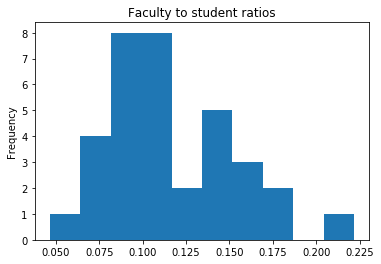

country sorted by their international student ratio


,country,total inter,total student,inter student ratio
1,Australia,106359.0,301994.0,0.352189
32,United Kingdom,199426.0,583621.0,0.341705
12,Hong Kong,24499.0,78838.0,0.310751
2,Austria,19667.0,63446.0,0.309980
30,Switzerland,32995.0,109112.0,0.302396
25,Singapore,16168.0,58466.0,0.276537
5,Canada,73239.0,281514.0,0.260161
21,New Zealand,12439.0,48173.0,0.258215
14,Ireland,8187.0,34794.0,0.235299
20,Netherlands,46044.0,197631.0,0.232980


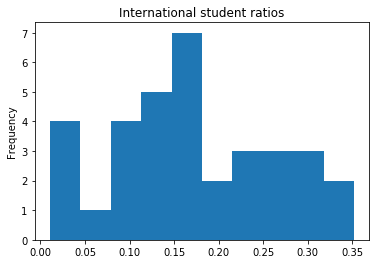

In [193]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per country\n"+END_STR)
ratio_analysis_per_column(topuniversities, "country")

Analysis of faculty to student ratio and international student ratio per region

Resulting dataframe sorted by region


,region,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Africa,3325.0,19593.0,1733.0,0.088450,0.169703
1,Asia,110100.0,807003.0,106734.0,0.132260,0.136431
2,Europe,449364.0,1957251.0,218358.0,0.111564,0.229589
3,Latin America,34737.0,396902.0,43126.0,0.108657,0.087520
4,North America,292116.0,1546353.0,182123.0,0.117776,0.188906
5,Oceania,118798.0,350167.0,25347.0,0.072385,0.339261


region sorted by their faculty to student ratio


,region,total faculty,total student,faculty student ratio
1,Asia,106734.0,807003.0,0.132260
4,North America,182123.0,1546353.0,0.117776
2,Europe,218358.0,1957251.0,0.111564
3,Latin America,43126.0,396902.0,0.108657
0,Africa,1733.0,19593.0,0.088450
5,Oceania,25347.0,350167.0,0.072385


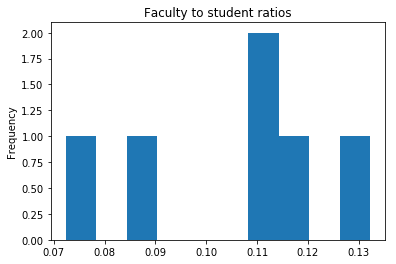

region sorted by their international student ratio


,region,total inter,total student,inter student ratio
5,Oceania,118798.0,350167.0,0.339261
2,Europe,449364.0,1957251.0,0.229589
4,North America,292116.0,1546353.0,0.188906
0,Africa,3325.0,19593.0,0.169703
1,Asia,110100.0,807003.0,0.136431
3,Latin America,34737.0,396902.0,0.087520


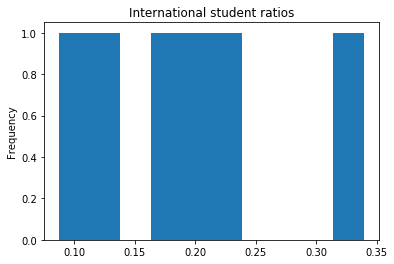

In [194]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per region\n"+END_STR)
ratio_analysis_per_column(topuniversities, "region")

<span class="burk">TODO: need to talk about what we see in data (histograms)</span>

### Analysis of ratios for the website timeshighereducation.com

In [29]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per school\n"+END_STR)
ratio_analysis_per_school(highereducation)

Analysis of faculty to student ratio and international student ratio per school

Dataframe with ratios


,country,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford,0.089274,0.379979
1,United Kingdom,2,Europe,University of Cambridge,1687.0,6436.0,18389,/world-university-rankings/university-cambridge,0.091740,0.349992
2,United States,3,North America,California Institute of Technology,340.0,596.0,2209,/world-university-rankings/california-institut...,0.153916,0.269805
3,United States,3,North America,Stanford University,2113.0,3486.0,15845,/world-university-rankings/stanford-university,0.133354,0.220006
4,United States,5,North America,Massachusetts Institute of Technology,1285.0,3800.0,11177,/world-university-rankings/massachusetts-insti...,0.114968,0.339984
5,United States,6,North America,Harvard University,2284.0,5285.0,20326,/world-university-rankings/harvard-university,0.112368,0.260012
6,United States,7,North America,Princeton University,958.0,1909.0,7955,/world-university-rankings/princeton-university,0.120427,0.239975
7,United Kingdom,8,Europe,Imperial College London,1391.0,8721.0,15857,/world-university-rankings/imperial-college-lo...,0.087722,0.549978
8,United States,9,North America,University of Chicago,2181.0,3381.0,13525,/world-university-rankings/university-chicago,0.161257,0.249982
9,Switzerland,10,Europe,ETH Zurich – Swiss Federal Institute of Techno...,1317.0,7309.0,19233,/world-university-rankings/eth-zurich-swiss-fe...,0.068476,0.380024


Schools sorted by their faculty to student ratio


,rank,country,region,title,total faculty,total student,faculty student ratio
105,105,United States,North America,Vanderbilt University,3640.0,12011,0.303056
109,109,Denmark,Europe,University of Copenhagen,7413.0,30395,0.243889
11,12,United States,North America,Yale University,2827.0,12155,0.232579
153,153,United States,North America,University of Rochester,2241.0,9636,0.232565
12,13,United States,North America,Johns Hopkins University,3604.0,15498,0.232546
97,98,United States,North America,Emory University,2875.0,12649,0.227291
16,17,United States,North America,Duke University,3390.0,15256,0.222208
114,115,France,Europe,École Polytechnique,549.0,2799,0.196141
183,184,Italy,Europe,Scuola Normale Superiore di Pisa,99.0,515,0.192233
101,100,United States,North America,University of Pittsburgh,4469.0,26367,0.169492


Schools sorted by their international student ratio


,rank,country,region,title,total inter,total student,inter student ratio
24,25,United Kingdom,Europe,London School of Economics and Political Science,7146.0,10065,0.709985
178,179,Luxembourg,Europe,University of Luxembourg,2832.0,4969,0.569934
7,8,United Kingdom,Europe,Imperial College London,8721.0,15857,0.549978
37,38,Switzerland,Europe,École Polytechnique Fédérale de Lausanne,5460.0,9928,0.549960
102,103,Netherlands,Europe,Maastricht University,8364.0,16727,0.500030
15,16,United Kingdom,Europe,University College London,14849.0,30304,0.490001
143,143,United Kingdom,Europe,University of St Andrews,4322.0,9005,0.479956
23,24,United States,North America,Carnegie Mellon University,5704.0,12676,0.449984
120,121,United Kingdom,Europe,Queen Mary University of London,6932.0,15405,0.449984
39,40,Hong Kong,Asia,University of Hong Kong,7713.0,18364,0.420007


In [30]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per country\n"+END_STR)
ratio_analysis_per_column(highereducation, "country")

Analysis of faculty to student ratio and international student ratio per country

Resulting dataframe sorted by country


,country,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Australia,83812.0,268630,9940.0,0.037003,0.311998
1,Austria,9198.0,35375,1701.0,0.048085,0.260014
2,Belgium,23769.0,130115,3428.0,0.026346,0.182677
3,Canada,55906.0,249401,13240.0,0.053087,0.224161
4,China,22883.0,253911,21390.0,0.084242,0.090122
5,Denmark,9327.0,64110,10598.0,0.165310,0.145484
6,Finland,3901.0,35276,2022.0,0.057319,0.110585
7,France,18975.0,99378,7437.0,0.074835,0.190938
8,Germany,87490.0,586364,15355.0,0.026187,0.149208
9,Hong Kong,25158.0,77663,4141.0,0.053320,0.323938


country sorted by their faculty to student ratio


,country,total faculty,total student,faculty student ratio
5,Denmark,10598.0,64110,0.165310
17,Russian Federation,4005.0,29236,0.136989
12,Japan,6465.0,48481,0.133351
11,Italy,158.0,1205,0.131120
23,Switzerland,10049.0,107852,0.093174
26,United States,152354.0,1705533,0.089329
24,Taiwan,2762.0,31758,0.086970
19,South Africa,1776.0,20775,0.085487
4,China,21390.0,253911,0.084242
7,France,7437.0,99378,0.074835


country sorted by their international student ratio


,country,total inter,total student,inter student ratio
13,Luxembourg,2832.0,4969,0.569934
25,United Kingdom,213058.0,596449,0.357211
9,Hong Kong,25158.0,77663,0.323938
0,Australia,83812.0,268630,0.311998
18,Singapore,17086.0,56101,0.304558
23,Switzerland,32746.0,107852,0.303620
15,New Zealand,8801.0,30348,0.290003
10,Ireland,4362.0,16157,0.269976
1,Austria,9198.0,35375,0.260014
3,Canada,55906.0,249401,0.224161


In [31]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per region\n"+END_STR)
ratio_analysis_per_column(highereducation, "region")

Analysis of faculty to student ratio and international student ratio per region

Resulting dataframe sorted by region


,region,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Africa,3740.0,20775,1776.0,0.085487,0.180024
1,Asia,78839.0,530949,42636.0,0.080301,0.148487
2,Europe,481576.0,2143623,126864.0,0.059182,0.224655
3,North America,336271.0,1954934,165594.0,0.084706,0.172011
4,Oceania,92613.0,298978,11554.0,0.038645,0.309765


region sorted by their faculty to student ratio


,region,total faculty,total student,faculty student ratio
0,Africa,1776.0,20775,0.085487
3,North America,165594.0,1954934,0.084706
1,Asia,42636.0,530949,0.080301
2,Europe,126864.0,2143623,0.059182
4,Oceania,11554.0,298978,0.038645


region sorted by their international student ratio


,region,total inter,total student,inter student ratio
4,Oceania,92613.0,298978,0.309765
2,Europe,481576.0,2143623,0.224655
0,Africa,3740.0,20775,0.180024
3,North America,336271.0,1954934,0.172011
1,Asia,78839.0,530949,0.148487


<span class="burk">TODO: need to talk about what we see in data (histograms)</span>

## Merging the two resulting DataFrames

We now want to merge the to dataframes we obtained into a single one, by using the name of the university as a reference point.  
We also want to keep the rank of each university in both website as a separate column in the resulting dataframe.


In [32]:
topuniversities.head(1)


,country,inter faculty,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United States,1679.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...,0.26945,0.335863


In [33]:

highereducation.head(1)

,country,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford,0.089274,0.379979


In [150]:
def compare_uni_titles(df1, df2):
    """ This function goes through the titles of the university in a ranking dataframe and print
        the name of the university that have not been found in the other.
        It should only be used as an indicator: some names might not be shared from one ranking to the other
    """
    
    for title in df1["title"]:
        #print(title)
        index = pd.Series([item == -1 for item in df2["title"].str.find(title)])
        if index.all():  
            print("Not found:", title)
    print("---------------------------------------------------------------------------------------------")
    for title in df2["title"]:
        #print(title)
        index = pd.Series([item == -1 for item in df1["title"].str.find(title)])
        if index.all():  
            print("Not found:", title)

In [79]:
# Universities in topuniversities contain their acronyme, we want to remove it
compare_uni_titles(highereducation, topuniversities)

Not found: ETH Zurich – Swiss Federal Institute of Technology Zurich
Not found: LMU Munich
Not found: King’s College London
Not found: École Polytechnique Fédérale de Lausanne
Not found: Karolinska Institute
Not found: Heidelberg University
Not found: Washington University in St Louis
Not found: University of North Carolina at Chapel Hill
Not found: Humboldt University of Berlin
Not found: Paris Sciences et Lettres – PSL Research University Paris
Not found: University of Freiburg
Not found: Free University of Berlin
Not found: Technical University of Berlin
Not found: University of Tübingen
Not found: Korea Advanced Institute of Science and Technology (KAIST)
Not found: University of Bonn
Not found: Vanderbilt University
Not found: University of Montreal
Not found: École Polytechnique
Not found: Indiana University
Not found: Radboud University Nijmegen
Not found: Georgetown University
Not found: Pierre and Marie Curie University
Not found: University of Mannheim
Not found: Arizona Stat

In [ ]:
# The result above are very troublesome: some university names are not written in english!
# Also, there's non-standard variation in the university names, would be hard to parse with regex!

In [81]:
import wikipedia

In [136]:
# We can try something that should be standardize: the name of the university on the wikipedia page and use this as
# the actual title of the university!
def get_uni_name_from_wikipedia(name_in_df):
    # get first element from the wikipedia search result and its associated wikipedia page
    wiki_page = wikipedia.page(wikipedia.search(name_in_df)[0])
    return wiki_page.title

In [142]:
if not USE_PICKLED_DATA:
    topuniversities_good_name = topuniversities
    for row in topuniversities_good_name.itertuples():
        proper_name = get_uni_name_from_wikipedia(row.title)
        topuniversities_good_name.set_value(row.Index, "title", proper_name)

    # To work without having to pull everything down.
    with open('top_uni_good_name.pickle', 'wb') as out:
        pickle.dump(topuniversities_good_name, out)

In [152]:
with open('top_uni_good_name.pickle', 'rb') as data_source:
    topuniversities_good_name = pickle.load(data_source)

In [148]:
if not USE_PICKLED_DATA:
    highereducation_good_name = highereducation
    for row in highereducation_good_name.itertuples():
        proper_name = get_uni_name_from_wikipedia(row.title)
        highereducation_good_name.set_value(row.Index, "title", proper_name)

    # To work without having to pull everything down.
    with open('higher_ed_good_name.pickle', 'wb') as out:
        pickle.dump(highereducation_good_name, out)

In [153]:
with open('higher_ed_good_name.pickle', 'rb') as data_source:
    highereducation_good_name = pickle.load(data_source)

In [154]:
compare_uni_titles(topuniversities_good_name, highereducation_good_name)

Not found: UCLA School of Law
Not found: École Normale Supérieure
Not found: New York University School of Law
Not found: Tokyo Institute of Technology
Not found: Osaka University
Not found: University of Buenos Aires
Not found: Tohoku University
Not found: Korea University
Not found: Yonsei University
Not found: University of Malaya
Not found: Nagoya University
Not found: University of São Paulo
Not found: National Autonomous University of Mexico
Not found: Hokkaido University
Not found: Kyushu University
Not found: Chalmers University of Technology
Not found: Pontifical Catholic University of Chile
Not found: Hebrew University of Jerusalem
Not found: University of Otago
Not found: University of Waterloo
Not found: Hanyang University
Not found: University of Bath
Not found: National Tsing Hua University
Not found: University of Bergen
Not found: University College Dublin
Not found: Polytechnic University of Milan
Not found: Indian Institute of Technology Delhi
Not found: King Fahd Uni

There's still universities that are not shared between the two list, but it looks as it is not caused by 
an error in naming, but because they are effectively not in the other list. We will accept this result for now and proceed with the merge of the Dataframes.

In [196]:

topuniversities_good_name.columns

Index(['country', 'inter faculty', 'rank', 'region', 'title', 'total faculty',
       'total inter', 'total student', 'url'],
      dtype='object')

In [217]:
# Clean up the dataframe for the merge
# Drop the url, not meaningfull anymore
# We use try in case it was already deleted
try:
    topuniversities_good_name.drop("url", axis=1, inplace=True)
except:
    pass
try:
    highereducation_good_name.drop("url", axis=1, inplace=True)
except:
    pass
# Drop the inter faculty from topuniversity, we don't have the info in
# the other dataframe so its meaningless in the future
try:
    topuniversities_good_name.drop("inter faculty", axis=1, inplace=True)
except:
    pass

# Change the column names so its not automatic
topuniversities_good_name.rename(columns = {"rank":"tu rank","total faculty":"tu total faculty", "total inter":"tu total inter", "total student":"tu total student"},inplace=True)
highereducation_good_name.rename(columns = {"rank":"he rank","total faculty":"he total faculty", "total inter":"he total inter", "total student":"he total student"},inplace=True)

# Merge
merged_rankings = pd.merge(topuniversities_good_name, highereducation_good_name,
                           how='outer', on=["title", "country", "region"] )
display(merged_rankings.head(10))

,country,tu rank,region,title,tu total faculty,tu total inter,tu total student,he rank,he total faculty,he total inter,he total student
0,United States,1.0,North America,Massachusetts Institute of Technology,2982.0,3717.0,11067.0,5.0,1285.0,3800.0,11177.0
1,United States,2.0,North America,Stanford University,4285.0,3611.0,15878.0,3.0,2113.0,3486.0,15845.0
2,United States,3.0,North America,Harvard University,4350.0,5266.0,22429.0,6.0,2284.0,5285.0,20326.0
3,United States,4.0,North America,California Institute of Technology,953.0,647.0,2255.0,3.0,340.0,596.0,2209.0
4,United Kingdom,5.0,Europe,University of Cambridge,5490.0,6699.0,18770.0,2.0,1687.0,6436.0,18389.0
5,United Kingdom,6.0,Europe,University of Oxford,6750.0,7353.0,19720.0,1.0,1822.0,7755.0,20409.0
6,United Kingdom,7.0,Europe,University College London,6345.0,14854.0,31080.0,16.0,2886.0,14849.0,30304.0
7,United Kingdom,8.0,Europe,Imperial College London,3930.0,8746.0,16090.0,8.0,1391.0,8721.0,15857.0
8,United States,9.0,North America,University of Chicago,2449.0,3379.0,13557.0,9.0,2181.0,3381.0,13525.0
9,Switzerland,10.0,Europe,ETH Zurich,2477.0,7563.0,19815.0,10.0,1317.0,7309.0,19233.0


In [227]:
# Lets manage the column names
new_cols=['region', 'country', 'title',
          'tu rank', 'tu total faculty', 'tu total inter', 'tu total student',
          'he rank', 'he total faculty', 'he total inter', 'he total student']
merged_rankings = merged_rankings[new_cols]

['region', 'country', 'title', 'tu rank', 'tu total faculty', 'tu total inter', 'tu total student', 'he rank', 'he total faculty', 'he total inter', 'he total student']


In [230]:
# Generate a new DataFrame with better labels for columns
col_name_per_ranking=['rank', 'total faculty', 'total inter', 'total student']
first_column=["University Info", "University Info", "University Info",
              "Top Universities", "Top Universities", "Top Universities", "Top Universities",
              "Higher Education", "Higher Education", "Higher Education", "Higher Education"]
second_column=["region", "country", "title"]+ col_name_per_ranking + col_name_per_ranking
merged_rankings = pd.DataFrame(data=merged_rankings.values,
                               index=merged_rankings.index,
                               columns=[first_column, second_column])

In [231]:
display(merged_rankings)

University Info                      \
             region             country   
0     North America       United States   
1     North America       United States   
2     North America       United States   
3     North America       United States   
4            Europe      United Kingdom   
5            Europe      United Kingdom   
6            Europe      United Kingdom   
7            Europe      United Kingdom   
8     North America       United States   
9            Europe         Switzerland   
10             Asia           Singapore   
11           Europe         Switzerland   
12    North America       United States   
13    North America       United States   
14             Asia           Singapore   
15    North America       United States   
16    North America       United States   
17    North America       United States   
18    North America       United States   
19          Oceania           Australia   
20    North America       United States   
21    North America       United States   
22           Europe      United Kingdom   
23           Europe      United Kingdom   
24             Asia               China   
25             Asia           Hong Kong   
26    North America       United States   
27             Asia               Japan   
28    North America       United States   
29             Asia           Hong Kong   
..              ...                 ...   
213          Europe      United Kingdom   
214   North America       United States   
215          Europe               Italy   
216          Europe             Germany   
217          Europe             Germany   
218   North America       United States   
219          Europe      United Kingdom   
220   North America       United States   
221   North America       United States   
222          Europe             Germany   
223          Europe         Netherlands   
224          Europe             Germany   
225   North America       United States   
226   North America       United States   
227   North America       United States   
228          Europe             Germany   
229          Europe             Belgium   
230          Europe          Luxembourg   
231          Europe              France   
232   North America       United States   
233          Europe      United Kingdom   
234          Europe      United Kingdom   
235   North America       United States   
236   North America       United States   
237          Europe  Russian Federation   
238          Europe         Netherlands   
239          Europe              France   
240          Europe      United Kingdom   
241   North America       United States   
242          Europe              Sweden   

                                                    Top Universities  \
                                              title             rank   
0             Massachusetts Institute of Technology                1   
1                               Stanford University                2   
2                                Harvard University                3   
3                California Institute of Technology                4   
4                           University of Cambridge                5   
5                              University of Oxford                6   
6                         University College London                7   
7                           Imperial College London                8   
8                             University of Chicago                9   
9                                        ETH Zurich               10   
10                 Nanyang Technological University               11   
11         École Polytechnique Fédérale de Lausanne               12   
12                             Princeton University               13   
13                               Cornell University               14   
14                 National University of Singapore               15   
15                                  Yale University               16  

## Analysing the resulting data